In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Описание проекта

Ретейлер "Лента" хочет научиться оптимизировать производство товаров. Необходимо построить модели, которые будут прогнозировать спрос на товары, чтобы не было недостатка и избытка в магазинах.

# План проекта

1. Изучить данные, проверить на наличие аномалий, неправильных типов и т.д. Отчистить данные от них (при необходимости);
2. Визуализировать полученные данные и сделать вывод;
3. Обучить модели с подбором параметров и выбрать среди них наилучшую;
4. Протестировать модель с лучшим показателем метрики и сделать выводы по итогам работы;


Необходимые библиотеки:

In [ ]:
!pip install  catboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from collections import Counter
warnings.filterwarnings('ignore')

---

# EDA

In [3]:
# данные по магазинам
st_df = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/st_df.csv')

# данные по иерархии товаров
pr_df = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/pr_df.csv')

# данные по продажам
sales_df_train = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/sales_df_train.csv')

# календарь
calendar = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/holidays_covid_calendar.csv')

In [4]:
# мерджим флаг активности
sales_df_train = pd.merge(sales_df_train, st_df[['st_id','st_is_active']], on='st_id', how='left')

In [5]:
# выбираем только рабочие магазины
sales_df_train = sales_df_train[sales_df_train['st_is_active'] == 1]

In [6]:
# избавляемся от возвратных позиций
sales_df_train = sales_df_train[sales_df_train['pr_sales_in_rub'] >= 0]

In [7]:
# информация по размеру дф
sales_df_train.shape

(882208, 9)

In [8]:
# создал переменную, куда скопировал основной дф
sales_df_train_1 = sales_df_train

In [9]:
# удаляем все строки, где объем продаж = 0
sales_df_train_1 = sales_df_train_1[sales_df_train_1['pr_sales_in_units'] != 0]

In [11]:
# удаляю строки, где сумма продаж по 1 позиции меньше 15 тыс. руб.
sales_df_train_1 = sales_df_train_1[sales_df_train_1['pr_sales_in_rub'] < 15000]

In [13]:
# агрегирую продажи по магазинам
gr_shop = sales_df_train_1.groupby('st_id').agg({'pr_sales_in_rub':'sum', 'pr_sales_in_units':'sum'}).reset_index()

In [14]:
# информация по суммарным продажам по магазинам
gr_shop.sort_values(by='pr_sales_in_units')

,st_id,pr_sales_in_rub,pr_sales_in_units
0,084a8a9aa8cced9175bd07bc44998e75,6836.0,49.0
6,bd470ca955d9497bbcb808e59952fffc,251196.0,5114.0
4,53e19f3dbb211f20b20b45668303c1b6,1072659.0,19227.0
2,1ecfb463472ec9115b10c292ef8bc986,8258219.0,129190.0
9,fa7cdfad1a5aaf8370ebeda47a1ff1c3,60084254.0,496844.0
5,6364d3f0f495b6ab9dcf8d3b5c6e0b01,61109229.0,498561.0
8,f7e6c85504ce6e82442c770f7c8606f0,70936095.0,638501.0
3,42a0e188f5033bc65bf8d78622277c4e,82711537.0,683572.0
1,16a5cdae362b8d27a1d8f8c7b78b4330,93872972.0,819797.0
7,c81e728d9d4c2f636f067f89cc14862c,106060125.0,938747.0


In [15]:
# удаляю первые три магазина, где меньше всего продаж
sales_df_train_1 = sales_df_train_1[~sales_df_train_1['st_id'].isin(['084a8a9aa8cced9175bd07bc44998e75',
                                                                  'bd470ca955d9497bbcb808e59952fffc',
                                                                  '53e19f3dbb211f20b20b45668303c1b6'])]

In [18]:
# находим стоимость за единицу продукции
sales_df_train_1['price'] = sales_df_train_1['pr_sales_in_rub'] / sales_df_train_1['pr_sales_in_units']

In [19]:
# вывожу строки, где цена = 0
sales_df_train_1[sales_df_train_1['price'] == 0].head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,st_is_active,price
30,f7e6c85504ce6e82442c770f7c8606f0,3474f0e025c7deb7e127a35763bc5512,2023-06-06,1,8.0,8.0,0.0,0.0,1,0.0
7432,c81e728d9d4c2f636f067f89cc14862c,90252502ab29331e94fd3113f11c58e0,2022-12-27,1,2.0,2.0,0.0,0.0,1,0.0
8153,f7e6c85504ce6e82442c770f7c8606f0,4e3d5c9fab3fc51a4857846fea3d2e57,2022-12-19,1,1.0,1.0,0.0,0.0,1,0.0
8931,f7e6c85504ce6e82442c770f7c8606f0,0f152427918d29bb1081834c1d375a48,2022-10-28,1,2.0,2.0,0.0,0.0,1,0.0
10269,f7e6c85504ce6e82442c770f7c8606f0,465e4f9b8d22467e46a6e02a78a40e97,2023-01-17,0,1.0,0.0,0.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...
876801,1ecfb463472ec9115b10c292ef8bc986,525526d5b2169462195c44d49fff4a44,2022-10-22,1,1.0,1.0,0.0,0.0,1,0.0
878163,fa7cdfad1a5aaf8370ebeda47a1ff1c3,27e8978c9e8b7146c462feb7d24f5637,2022-10-27,1,9.0,9.0,0.0,0.0,1,0.0
882360,6364d3f0f495b6ab9dcf8d3b5c6e0b01,2dc922d957188fb51dd2bd50ec9b555a,2022-10-29,1,12.0,12.0,0.0,0.0,1,0.0
882380,f7e6c85504ce6e82442c770f7c8606f0,9da31b9d3cf407cd724c65b7dfed00ee,2022-11-27,1,3.0,3.0,0.0,0.0,1,0.0


In [20]:
# удаляю строки, где price = 0
sales_df_train_1.drop(sales_df_train_1[sales_df_train_1['price'] == 0].index, inplace=True)

In [22]:
# небольшие махинации для дальнейшего метода merge
sales_df_train_1.drop(columns='st_is_active', inplace=True)
calendar['calday'] = calendar['calday'].astype(str)
sales_df_train_1['date'] = pd.to_datetime(sales_df_train_1['date']).dt.strftime('%Y%m%d')

In [23]:
sales_df_train_1 = pd.merge(sales_df_train_1, calendar, left_on='date',
                          right_on='calday', how='left')

In [24]:
# приводим в приличный вид
sales_df_train_1.drop(columns='date_y', inplace=True)
sales_df_train_1.rename(columns={'date_x':'date'}, inplace=True)

In [25]:
# добавляем фич с номером месяца
sales_df_train_1['month'] = sales_df_train_1['calday'].str[4:6]

In [26]:
# добавляем фичи с товарной иерархией
sales_df_train_1 = pd.merge(sales_df_train_1, pr_df, on='pr_sku_id', how='left')

In [27]:
# добавляем фичи с данными по магазинам
sales_df_train_1 = pd.merge(sales_df_train_1, st_df, on='st_id', how='left')

In [28]:
# описательная статистика продаж без промо
sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 0]['pr_sales_in_rub'].describe()

count    482892.000000
mean        532.769027
std         911.088761
min           1.000000
25%         133.000000
50%         270.000000
75%         571.000000
max       14996.000000
Name: pr_sales_in_rub, dtype: float64

In [29]:
# описательная статистика продаж с промо
sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 1]['pr_sales_in_rub'].describe()

count    318886.000000
mean        707.972536
std        1432.377995
min           1.000000
25%          96.000000
50%         228.000000
75%         643.000000
max       14985.000000
Name: pr_sales_in_rub, dtype: float64

In [30]:
print('Обычные продажи в %:',
      round(sales_df_train_1['pr_sales_type_id'].value_counts()[0]/len(sales_df_train_1) * 100))
print('Промо продажи в %:',
      round(sales_df_train_1['pr_sales_type_id'].value_counts()[1]/len(sales_df_train_1) * 100))

Обычные продажи в %: 60
Промо продажи в %: 40


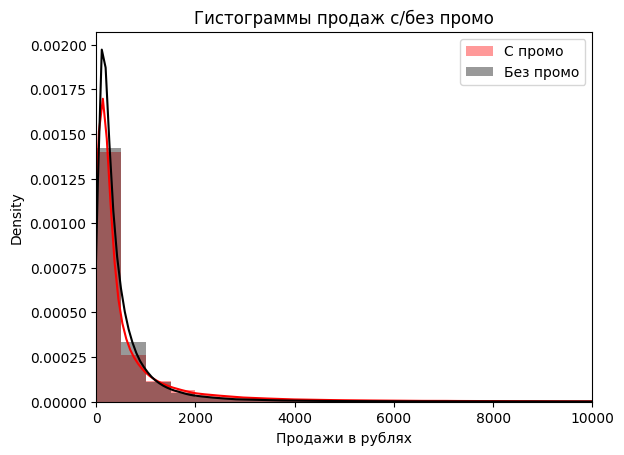

In [31]:
# гистограммы
sns.distplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 1]['pr_sales_in_rub'],
             label='С промо', color='red', bins=30)

sns.distplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 0]['pr_sales_in_rub'],
             label='Без промо', color='black', bins=30)

plt.xlabel('Продажи в рублях')
plt.title('Гистограммы продаж с/без промо')
plt.xlim(0, 10000)
plt.legend()
plt.show()

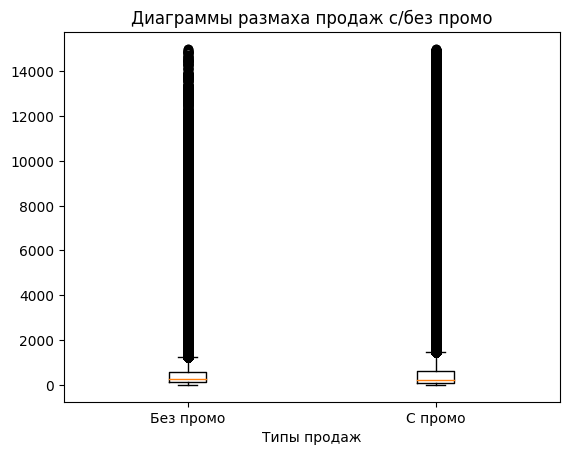

In [32]:
# диаграммы размаха
fig, ax = plt.subplots()

ax.boxplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 0]['pr_sales_in_rub'],
           positions=[1], labels=['Без промо'])

ax.boxplot(sales_df_train_1[sales_df_train_1['pr_sales_type_id'] == 1]['pr_sales_in_rub'],
           positions=[2], labels=['С промо'])

ax.set_xlabel('Типы продаж')
ax.set_title('Диаграммы размаха продаж с/без промо')
plt.show()

In [33]:
# продажи по месяцам
month_sales = sales_df_train_1.groupby(['year', 'month']).agg({'pr_sales_in_units':'sum'}).reset_index()

Text(0, 0.5, 'Кол-во товара')

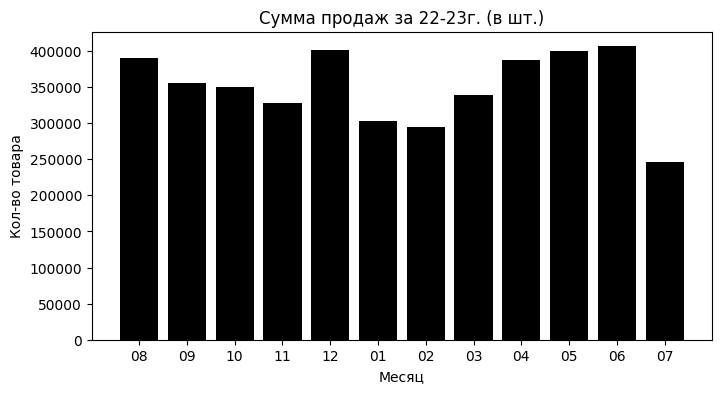

In [34]:
plt.figure(figsize=(8, 4))
plt.bar(month_sales['month'], month_sales['pr_sales_in_units'], color='black')
plt.title("Сумма продаж за 22-23г. (в шт.)")
plt.xlabel("Месяц")
plt.ylabel("Кол-во товара")

В процессе EDA было выполнено:
- Отобраны только активные магазины по флагу;
- Были удалены возвратные позиции, строки с объемом продаж = 0, строки с продажами более 15 тыс. руб.;
- Были удалены магазины (3 шт.), где продажи были слишком малы по сравнению с другими магазинами;
- Удалены также строки, где цена = 0;
- Добавлены фичи: номер месяца, товарная иерархия, данные по магазинам;
- Из описательной статистики по продажам можно сделать выводы:
	  a. Средняя покупка без промо - 532 руб., с промо 707 руб.;
	  b. Лишь 40% продаж приходится на промо%.
- Построены гистрограммы продаж из которых видно, что большая часть продажь - до 2 тыс. руб.;
- На диаграммах размаха видно, что есть много аномалий, однако не все аномалии - плохо, принято решение оставить эти выбросы;
- Из графика "Сумма продаж за..." можно сделать вывод, что в Декабре продажи резко подскакивают, также рост продаж отмечается и в весенний период, когда много праздников и теплеет, летом замечен спад. Вероятно, люди уезжают кто куда и спрос на товары падает.

---

# Обучение моделей

In [50]:
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

state=17

In [51]:
# фичи
X = sales_df_train_1.drop(columns=['pr_sales_in_units'])

# таргет
y = sales_df_train_1['pr_sales_in_units']

In [76]:
cat_features = X.select_dtypes(include='object').columns.to_list()
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features]

In [88]:
# задаем параметры модели
%%time
cb_model = CatBoostRegressor(
    loss_function='MAE',
    cat_features=cat_feature_indices,
    silent=True
)

# params = {
#     'learning_rate': [0.03, 0.1],
#     'depth': [4, 6, 10],
#     'l2_leaf_reg': [1, 5, 9]
# }

tscv = TimeSeriesSplit(n_splits=3)

mae_scores = []  # Список для сохранения MAE для каждого фолда
wape_scores = []  # Список для сохранения WAPE для каждого фолда

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Обучение модели и оценка с учетом временной последовательности
    cb_model.fit(X_train, y_train)
    y_pred = cb_model.predict(X_test)

    # Расчет MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Расчет WAPE
    wape = np.sum(np.abs(y_test - y_pred)) / np.sum(np.abs(y_test))

    mae_scores.append(mae)
    wape_scores.append(wape)

# Вывод средних значений MAE и WAPE для всех фолдов
average_mae = np.mean(mae_scores)
average_wape = np.mean(wape_scores)

print("Средний MAE:", average_mae)
print("Средний WAPE:", average_wape)

Средний MAE: 0.2537925366527727
Средний WAPE: 0.04839657823661539
CPU times: user 50min 35s, sys: 10.2 s, total: 50min 46s
Wall time: 30min 32s


! **ВАЖНО** ! Здесь будет ошибка. Не очень понятно, как сдавать sales_submission, если модель обучается на большом кол-ве фичей, а тут на вход подаются лишь код магазина, код товара и дата.

In [86]:
sales_submission = pd.read_csv(r'/content/drive/MyDrive/sp_sales_task/sales_submission.csv')

In [92]:
sales_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43694 entries, 0 to 43693
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   st_id      43694 non-null  object
 1   pr_sku_id  43694 non-null  object
 2   date       43694 non-null  object
 3   target     43694 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.3+ MB


In [93]:
predictions = []
for index, row in sales_submission.iterrows():
    shop = row['st_id']
    product = row['pr_sku_id']
    date = row['date']

    # Выполнение предсказания с использованием модели
    prediction = cb_model.predict([shop, product, date])[0]

    predictions.append(prediction)

# Запись предсказаний в колонку "target" в submission_data
sales_submission['target'] = predictions

CatBoostError: ignored